In [1]:
import os
os.chdir('../../')

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from spikelearn.data import io, SHORTCUTS, select, to_feature_array, remove_baseline
from spikelearn.models.shuffle_decoding import shuffle_val_predict

#from xgboost import XGBClassifier, XGBRegressor
%load_ext autoreload
%autoreload 2

from spikelearn.data.selection import frankenstein

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [2]:
import pandas as pd

In [1]:
sns.set_style('darkgrid')
plt.style.use('seaborn-darkgrid')
mpl.rc("figure", figsize=(10,6) )
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.facecolor'] = (1,1,1,0)
mpl.rcParams['figure.facecolor'] = (1,1,1,0)
sns.set_palette('deep', color_codes=True)

In [3]:
from catboost import CatBoostRegressor

In [4]:
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GroupShuffleSplit

In [5]:
from xgboost import XGBRegressor

In [ ]:
%matplotlib inline

clf.fit(fr.iloc[:1000].values,fr.iloc[:1000].reset_index().time.values ==300,  eval_set=(fr.iloc[1000:1200].values, fr.iloc[1000:1200].reset_index().time.values==300), plot=True, cat_features=[])

In [118]:
# Merging rats
DR = [io.load(label, 'wide_smoothed') for label in SHORTCUTS['groups']['DRRD']]
EZ = [io.load(label, 'wide_smoothed') for label in SHORTCUTS['groups']['EZ']]

sp_pfc = frankenstein(DR, _min_duration=1.5, is_selected=True, is_tired=False, subset='full')
sp_pfc = sp_pfc[(sp_pfc.reset_index('time').time>=200).values & (sp_pfc.reset_index('time').time<1300).values]

ez_pfc = frankenstein(EZ, _min_duration=1.5, _min_quality=0, area='PFC', subset='full')
ez_pfc = ez_pfc[(ez_pfc.reset_index('time').time>=200).values & (ez_pfc.reset_index('time').time<1300).values]

ez_str = frankenstein(EZ, _min_duration=1.5, _min_quality=0, area='STR', subset='full')
ez_str = ez_str[(ez_str.reset_index('time').time>=200).values & (ez_str.reset_index('time').time<1300).values]
merged_rats = [sp_pfc, ez_pfc, ez_str]

In [121]:
DR = [select(io.load(label, 'wide_smoothed'), is_selected=True, is_tired=False) for label in SHORTCUTS['groups']['DRRD']]
EZ = [select(io.load(label, 'wide_smoothed'),_min_quality=0) for label in SHORTCUTS['groups']['EZ']]
bigfrank= frankenstein(DR+EZ,  _min_duration=1.5, subset='cropped')

In [10]:
import pandas as pd

# Regression

## XGBoost

In [26]:
%%time
sh = GroupShuffleSplit(n_splits=1, train_size=.8, test_size=.2)
res = pd.DataFrame()
X, y, trial = sp_pfc.values, sp_pfc.reset_index().time.values, sp_pfc.reset_index().trial.values
for train_idx, test_idx in sh.split(X, y, trial):
    
    clf.fit(X[train_idx], y[train_idx])
    
    local = pd.DataFrame()
    local['pred'] = clf.predict(X[test_idx])
    local['true'] = y[test_idx]
    res=res.append(local)

CPU times: user 1.59 s, sys: 11.1 ms, total: 1.6 s
Wall time: 1.6 s


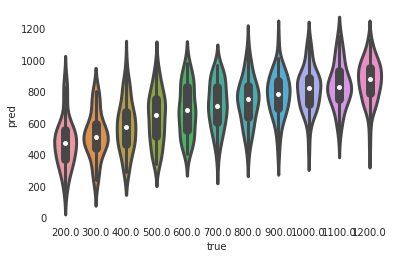

In [29]:
sns.violinplot(x='true',y='pred', data=res)

<Figure size 432x288 with 0 Axes>

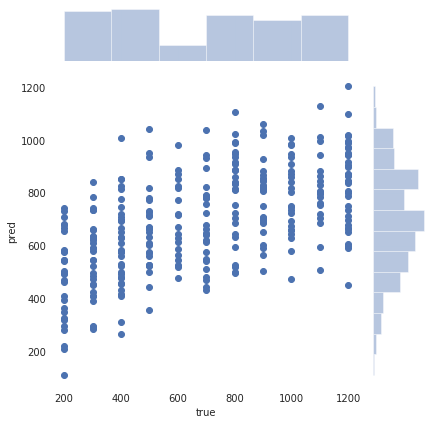

In [80]:
fig = plt.figure()
r = res.sample(300)
sns.jointplot(r.true, r.pred)
plt.savefig('teste.eps')


## Catboost

In [4]:
clf= CatBoostRegressor(verbose=False)

In [13]:
%%time
sh = GroupShuffleSplit(n_splits=10, train_size=.8, test_size=.2)
res = pd.DataFrame()
X, y, trial = sp_pfc.values, sp_pfc.reset_index().time.values, sp_pfc.reset_index().trial.values
for i, (train_idx, test_idx) in enumerate(sh.split(X, y, trial)):
    
    clf.fit(X[train_idx], y[train_idx])
    
    local = pd.DataFrame()
    local['pred'] = clf.predict(X[test_idx])
    local['true'] = y[test_idx]
    local['cv'] = i
    res=res.append(local)


Iteration with suspicious time 1.9 sec ignored in overall statistics.
CPU times: user 1h 3min 28s, sys: 1min 20s, total: 1h 4min 49s
Wall time: 1min 49s


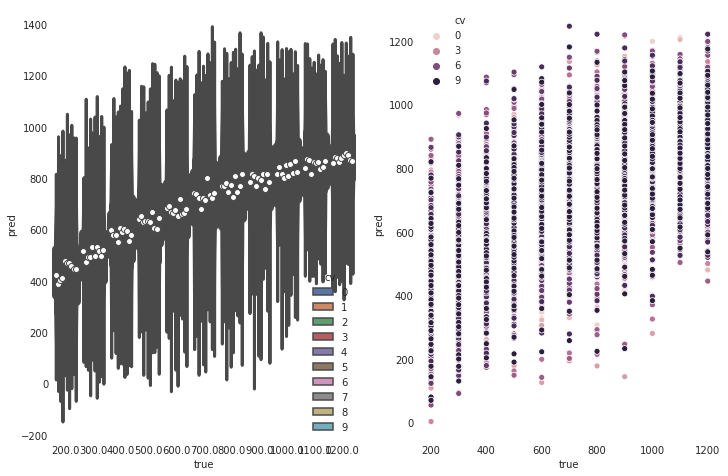

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12,8))
sns.violinplot(x='true',y='pred', hue='cv', data=res, ax=ax[0])
sns.scatterplot(x='true',y='pred', hue='cv',data=res, ax=ax[1], x_jitter=True)

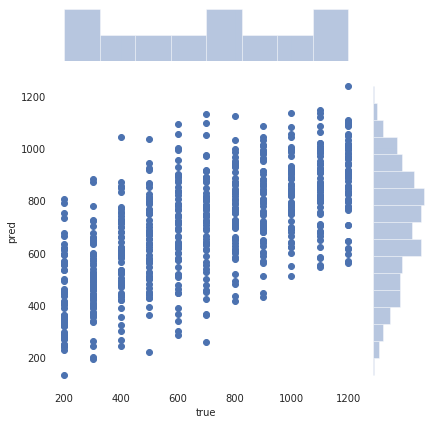

In [49]:
sns.jointplot(res.true, res.pred)

In [50]:
explained_variance_score(res.true, res.pred)

0.4253666349984705

In [28]:
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.metrics import make_scorer

from scipy.stats import pearsonr
pearson = lambda t, p: pearsonr(t, p)[0]

import numpy as np

from imblearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.base import SamplerMixin, BaseSampler

In [ ]:
%%time
scoring={'exp':'explained_variance', 'pearsonr':make_scorer(pearson)}
clf = CatBoostRegressor(verbose=False, l2_leaf_reg=1000)
res_start = cross_validate(clf, start.values, start.reset_index().time, start.reset_index().trial, 
                             cv = GroupShuffleSplit(10), scoring=scoring, return_train_score=False)
res_end = cross_validate(clf, end.values, end.reset_index().time, end.reset_index().trial, 
                             cv = GroupShuffleSplit(10), scoring=scoring, return_train_score=False)

In [30]:
scoring={'exp':'explained_variance', 'pearsonr':make_scorer(pearson)}

In [55]:
class MonteCarloSelect(BaseSampler, SamplerMixin):
    def __init__(self, n_features):
        self.n_groups = n_groups
        self.n_features = n_features
        self.group_col = group_from_df
        self.ratio=None
        self.sampling_strategy=None
        self._sampling_type = 'under-sampling'
        self.features_ = None
        
    def fit(self,X, y):
        print(type(X), X.shape)
        assert type(X) is pd.DataFrame
        assert X.shape[1] >= self.n_features
        self.features_ = np.random.permutation(X.columns.values)[:self.n_features]
        group = X.reset_index()[self.group_col]
        assert group.nunique() >= self.n_groups
        
        return self
    
    def sample(self,X, y=None):
        assert type(X) is pd.DataFrame
        assert X.shape[1] >= self.n_features
        group = X.reset_index()[self.group_col]
        
        groups = np.random.permutation(group.unique())[:self.n_groups]
        return X.loc[group.isin(groups).values, self.features_], group[group.isin(groups)]
        
    def fit_sample(self,X,y=None):
        return self.fit(X, y).transform(X,y)
    
    def _resample(self,X, y=None):
        assert type(X) is pd.DataFrame
        assert X.shape[1] >= self.n_features
        group = X.reset_index()[self.group_col]
        
        groups = np.random.permutation(group.unique())[:self.n_groups]
        return X.loc[group.isin(groups).values, self.features_], group[group.isin(groups)]
        
    def _fit_resample(self,X,y=None):
        return self.fit(X, y).transform(X,y)

In [67]:
class MonteCarloFeatures(TransformerMixin):
    def __init__(self, n_features):
        self.n_features = n_features
        self.features_ = None
        
    def fit(self,X, y):
        assert type(X) is pd.DataFrame
        assert X.shape[1] >= self.n_features
        self.features_ = np.random.permutation(X.columns.values)[:self.n_features]        
        return self
    
    def transform(self,X, y=None):
        assert type(X) is pd.DataFrame
        assert X.shape[1] >= self.n_features
        return X[self.features_]
                
    def fit_transform(self,X,y=None):
        return self.fit(X, y).transform(X,y)

In [86]:
from sklearn.linear_model import BayesianRidge

CPU times: user 3min 37s, sys: 4min 19s, total: 7min 56s
Wall time: 12.1 s


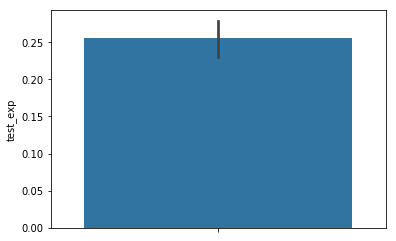

In [162]:
%%time
pipe = make_pipeline(MonteCarloFeatures(200), BayesianRidge())
res30 = pd.DataFrame(cross_validate(pipe, bigfrank, bigfrank.reset_index().time, bigfrank.reset_index().trial, 
                             cv = GroupShuffleSplit(100, train_size=train_size, test_size=.1),
                             scoring=scoring, return_train_score=False))
sns.barplot(y='test_exp', data=res30)

In [163]:
from sklearn.svm import SVR

In [165]:
from sklearn.preprocessing import StandardScaler

CPU times: user 1.5 s, sys: 745 µs, total: 1.5 s
Wall time: 1.5 s


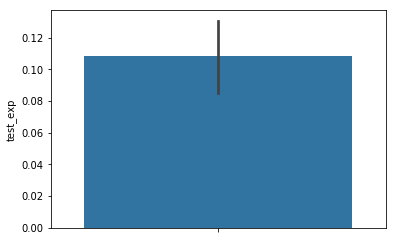

In [172]:
%%time
pipe = make_pipeline(MonteCarloFeatures(30), StandardScaler(), SVR('linear', C=.1, gamma='auto'))
res30 = pd.DataFrame(cross_validate(pipe, bigfrank, bigfrank.reset_index().time, bigfrank.reset_index().trial, 
                             cv = GroupShuffleSplit(10, train_size=train_size, test_size=.1),
                             scoring=scoring, return_train_score=False))
sns.barplot(y='test_exp', data=res30)

In [178]:
%%time
train_size=.9
res = pd.DataFrame()
for rat in SHORTCUTS['groups']['day1']:
    if 'DRRD' in rat:
        print(rat)
        data = select(io.load(rat, 'wide_smoothed'), is_tired=False, is_selected=True, _min_duration=1.5)
        df = to_feature_array(data, False, 'cropped')
        start, end = df.iloc[:int(df.shape[0]/2)], df.iloc[int(df.shape[0]/2):]
        
    else:
        print(rat)
        start = to_feature_array(select(io.load(rat, 'wide_smoothed'), is_tired=False, area='PFC', 
                                       _min_quality=0, _min_duration=1.5))
        end = to_feature_array(select(io.load(rat+'_2', 'wide_smoothed'), is_tired=False, area='PFC', 
                                       _min_quality=0, _min_duration=1.5))
        start, end = start.iloc[:min(start.shape[0], end.shape[0])], end.iloc[:min(start.shape[0], end.shape[0])]
        
    mcs = MonteCarloFeatures(min(start.shape[1], end.shape[1]))
#     clf = make_pipeline(mcs, LinearDiscriminantAnalysis('lsqr', 'auto'))
    clf = make_pipeline(mcs, BayesianRidge())
    res_start = pd.DataFrame(cross_validate(clf, start, start.reset_index().time, start.reset_index().trial, 
                             cv = GroupShuffleSplit(30, train_size=train_size, test_size=.1),
                             scoring=scoring, return_train_score=False))
    res_end = pd.DataFrame(cross_validate(clf, end, end.reset_index().time, end.reset_index().trial, 
                             cv = GroupShuffleSplit(30, train_size=train_size, test_size=.1),
                             scoring=scoring, return_train_score=False))

    res_end['when'] = 'end'
    res_start['when'] = 'start'
    res_end['rat'] = rat
    res_start['rat'] = rat
    res_end['n_neurons'] = mcs.n_features
    res_start['n_neurons'] = mcs.n_features
    res = res.append(res_end).append(res_start)

DRRD 7
DRRD 8
DRRD 9
DRRD 10
ELI 3
ELI 4
ELI 5
ELI 6
CPU times: user 3min 34s, sys: 5min, total: 8min 35s
Wall time: 27.1 s


In [117]:
res.n_neurons.value_counts()

68    60
28    60
24    60
23    60
14    60
4     60
3     60
2     60
Name: n_neurons, dtype: int64

In [177]:
res = res.filter(regex='test').rename(columns=lambda s: s[5:])\
        .reset_index(drop=True).join(res.reset_index(drop=True)[['rat','when']])

KeyError: "['when'] not in index"

In [175]:
res['Is proficient'] = res.when=='end'

res = res.melt(id_vars=[ 'Is proficient', 'rat'], value_vars=['exp', 'pearsonr'])
# resvar = res.melt(id_vars=['Is proficient', 'rat'], value_vars=['exp, pearsonr'])

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


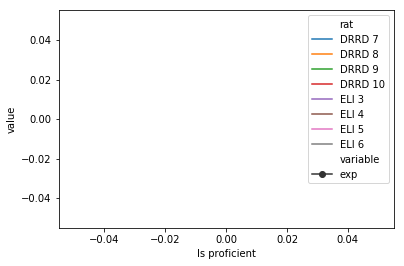

In [176]:
sns.lineplot(x='Is proficient', y='value', style='variable', hue='rat',
             data=res[res.variable=='exp'], err_style='bars', markers=['o','^'], markersize=10)

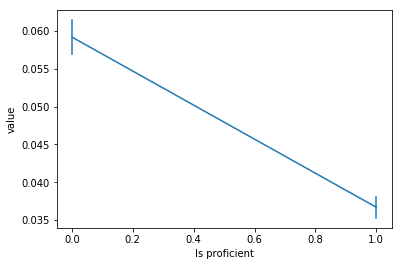

In [103]:
sns.lineplot(x='Is proficient', y='value',
             data=res[res.variable=='exp'], err_style='bars', markers=['o','^'], markersize=10)

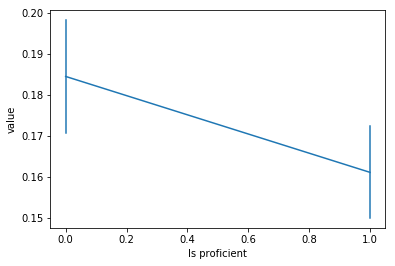

In [98]:
sns.lineplot(x='Is proficient', y='value',
             data=res[res.variable=='pearsonr'], err_style='bars', markers=['o','^'], markersize=10)

## Linear

In [106]:
from sklearn.linear_model import ElasticNetCV

In [136]:
clf = ElasticNetCV(max_iter=100, l1_ratio=.99)

In [142]:
from sklearn.model_selection import ShuffleSplit

In [175]:
%%time
scoring={'exp':'explained_variance', 'pearsonr':make_scorer(pearson)}
clf = LinearDiscriminantAnalysis()
res_start = cross_validate(clf, start.values, start.reset_index().time, start.reset_index().trial, 
                             cv = GroupShuffleSplit(50), scoring=scoring)
res_end = cross_validate(clf, end.values, end.reset_index().time, end.reset_index().trial, 
                             cv = GroupShuffleSplit(50), scoring=scoring)

CPU times: user 13.5 s, sys: 1.36 s, total: 14.8 s
Wall time: 770 ms


In [176]:
res_end = pd.DataFrame(res_end)
res_end['when'] = 'end'

res_start = pd.DataFrame(res_start)
res_start['when'] = 'start'

res = res_start.append(res_end)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_exp'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_pearsonr'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [177]:
respearson = res.melt(id_vars=['when'], value_vars=['test_pearsonr','train_pearsonr'])
resvar = res.melt(id_vars=['when'], value_vars=['test_exp','train_exp'])

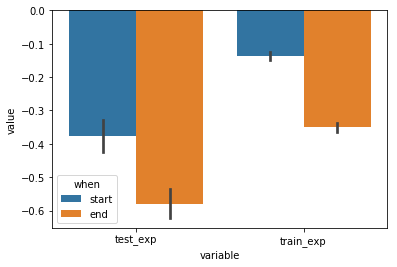

In [178]:
sns.barplot(x='variable', y='value', hue='when',data=resvar, ax=ax[0])
sns.barplot(x='variable', y='value', hue='when',data=respearson, ax=ax[1])

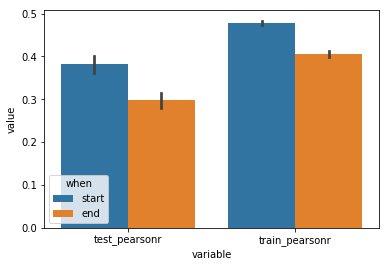

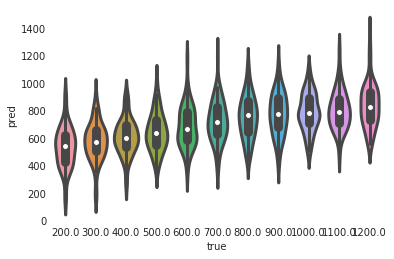

In [35]:
sns.violinplot(x='true',y='pred', data=res)

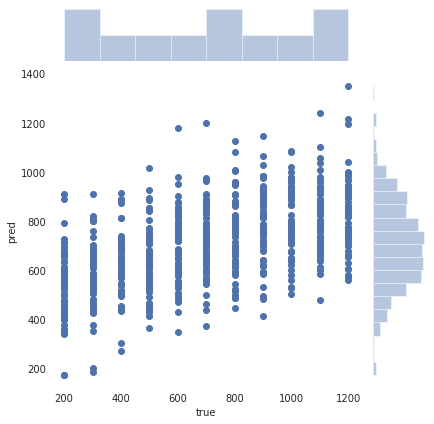

In [34]:
sns.jointplot(res.true, res.pred)